# BAITS.st.module -  Spatial cluster by gene-expression and spatial location

Except for clustering the spatially close cells, we can also cluster the gene-expression similar domains. In this part, we will spatial cluster the domains based on [**CellCharter**](https://cellcharter.readthedocs.io/en/stable/). 


### Import packages and data

In [2]:
import BAITS
import os
import anndata as ad
import numpy as np
import scanpy as sc


**Users could access the data through the following [link](https://baits.pku-genomics.org/#/download)**

In [4]:
adata = sc.read("/home/zhaoyp/1.CRLM_XCR/BAITS_temp/data/twosamples.h5ad") 


In [5]:
adata

AnnData object with n_obs × n_vars = 968003 × 25091
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'celltype', 'sample'
    var: 'mt'
    obsm: 'spatial'

### Data preprocessing

In [6]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)

# Logarithmize the data
sc.pp.log1p(adata)


### Gene expression matrix process

Dimensionality reduction - Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [7]:
sc.tl.pca(adata)


Integrate gene expression matrix of multiple samples

In [8]:
sc.external.pp.harmony_integrate(adata, key='sample', basis='X_pca' ) 


2025-12-01 19:15:47,029 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-12-01 19:17:28,826 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-01 19:17:33,057 - harmonypy - INFO - Iteration 1 of 10
2025-12-01 19:24:47,988 - harmonypy - INFO - Iteration 2 of 10
2025-12-01 19:32:11,630 - harmonypy - INFO - Iteration 3 of 10
2025-12-01 19:39:32,970 - harmonypy - INFO - Iteration 4 of 10
2025-12-01 19:46:19,260 - harmonypy - INFO - Iteration 5 of 10
2025-12-01 19:49:55,467 - harmonypy - INFO - Iteration 6 of 10
2025-12-01 19:52:13,474 - harmonypy - INFO - Iteration 7 of 10
2025-12-01 19:54:28,715 - harmonypy - INFO - Iteration 8 of 10
2025-12-01 19:56:53,073 - harmonypy - INFO - Iteration 9 of 10
2025-12-01 19:59:11,786 - harmonypy - INFO - Iteration 10 of 10
2025-12-01 20:01:35,603 - harmonypy - INFO - Stopped before convergence


In [9]:
adata


AnnData object with n_obs × n_vars = 968003 × 25091
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'celltype', 'sample'
    var: 'mt'
    uns: 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

### Spatial clustering  (cellCharter)

It is now time to compute the spatial clusters. All cells of each sample are encoded into networks. Every cell is a node and two cells are connected by an edge if they are physically close to each other in the tissue. 


In [10]:
BAITS.st.gr.spatial_neighbors(adata, sample_key='sample', coord_type='generic', delaunay=True, spatial_key='spatial') 


The next step is the neighborhood aggregation. It consists of concatenating the features of every cell with the features aggregated from neighbors ad increasing layers from the considered cell, up to a certain layer n_layers. Aggregation functions are used to obtain a single feature vector from the vectors of multiple neighbors, with the default being the mean function.

In this case we use 3 layers of neighbors, so we obtain, for each cell, a feature vector of length 40. That is the cell’s reduced vector size from PCA plus the aggregated vectors from the 3 layers of neighbors.



In [11]:
BAITS.st.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_pca') 


  0%|          | 0/2 [00:00<?, ?it/s]

We create the Gaussian Mixture model, specifying 12 as desired number of clusters. This value was obtained from the cluster stability analysis. For more details, you can check our paper.

In [12]:
gmm = BAITS.st.tl.Cluster(
    n_clusters=10, random_state=12345,
    # If running on GPU 
    # trainer_params=dict(accelerator='gpu', devices=1)
)

In [13]:
gmm.fit(adata, use_rep='X_cellcharter')
adata.obs['spatial_cluster'] = gmm.predict(adata, use_rep='X_cellcharter')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIB

Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [15]:
adata

AnnData object with n_obs × n_vars = 968003 × 25091
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'celltype', 'sample', 'spatial_cluster'
    var: 'mt'
    uns: 'log1p', 'pca', 'spatial_neighbors', '_cellcharter'
    obsm: 'spatial', 'X_pca', 'X_pca_harmony', 'X_cellcharter'
    varm: 'PCs'
    obsp: 'spatial_connectivities', 'spatial_distances'

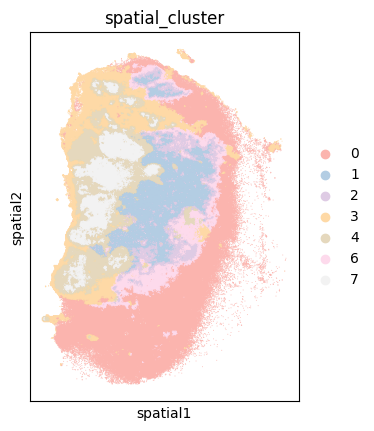

In [25]:
# 要画两个样本的
sc.pl.spatial(adata[adata.obs['sample']=='P0516_LM'], color=['spatial_cluster'], spot_size=50, palette='Pastel1') 
